# Time Series Analysis of Motor Collisions in Seattle

If you're here you're probably looking for my time series analysis. Sorry! This will be uploaded over the weekend, by Sunday 8/25.

## The Data

Available for download [here](https://data.seattle.gov/widgets/vac5-r8kk).

200K motor vehicle collisions provided by the city of Seattle, which occurred between 2004 and 2018. Each has date, some have associated time. Each one also has a `SEVERITYCODE`, which is described as follows:

  - **0**: Unknown
  - **1**: Property Damage Only
  - **2**: Injury Collision
  - **2b**: Serious Injury Collision
  - **3**: Fatal Collision
  
For my purposes, I will be joining severity `2` and `2b`, 
I am primarily interested in predicting the number of collisions that will happen on given days. I also will be interested in predicting the number of severity 1, 2, and 3 collisions.

## The Question

1. Can I predict how many accidents will occur next year?
1. Cell phones became popular circa 2012, and people seem to think this led to an increase in distracted driving. Is this present in the data?
1. Are there more/less dangerous times of year?
1. 

In [1]:
import pandas as pd
import numpy as np

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pkgs = [matplotlib, pd, np, sns, sm]
for pkg in pkgs:
    print(f'{pkg.__name__}: {pkg.__version__}')

matplotlib: 3.0.3
pandas: 0.24.2
numpy: 1.16.2
seaborn: 0.9.0
statsmodels: 0.9.0


In [2]:
data = pd.read_csv('data/seattle_collisions.csv')
data = data[['INCDTTM', 'SEVERITYCODE']]
data.INCDTTM = pd.to_datetime(data.INCDTTM)
data.head()

,INCDTTM,SEVERITYCODE
0,2013-04-07 09:12:00,2
1,2018-12-16 00:11:00,2
2,2018-11-27 00:00:00,0
3,2018-12-05 18:25:00,1
4,2018-12-10 12:46:00,2


In [3]:
data.dtypes

INCDTTM         datetime64[ns]
SEVERITYCODE            object
dtype: object

# Data Wrangling

## Severity Codes

From my previous work, I know I have to work with the severity codes a bit -- there is one missing (it doesn't matter, I'll just set it to `0`) and there's level '2' (injury collision) and '2b' (serious injury collision) which I'll just merge.

In [4]:
data.SEVERITYCODE.value_counts()

1     130533
2      55427
0      20394
2b      2918
3        319
Name: SEVERITYCODE, dtype: int64

In [5]:
data.SEVERITYCODE.isna().sum()

1

In [6]:
data.SEVERITYCODE.unique()

array(['2', '0', '1', '2b', '3', nan], dtype=object)

In [7]:
severity_dict = {'0':0, '1':1, '2':2, '2b':2, '3':3, np.nan:0}

data.SEVERITYCODE = data.SEVERITYCODE.map(severity_dict)

## Dates vs Times

Currently I have the column `INCDTTM` but I should add a `DATE` column to help with time series analysis, since this will allow us to group by date. It could also be handy to keep the time of these incidents around.

This might be tricky because one part of time series analysis is that we want observations to be taken at regular intervals, which the times are not. Using dates is my way of sticking to this assumption -- counting the number of collisions that occured on a given day is equivalent to counting the new collisions every day at midnight.

In [8]:
data['DAY'] = data.INCDTTM.dt.date

In [9]:
data.DAY = data.DAY.map(pd.to_datetime)

In [10]:
data.dtypes

INCDTTM         datetime64[ns]
SEVERITYCODE             int64
DAY             datetime64[ns]
dtype: object

## Does any date not appear?

My inspection here shows that there was a single collision recorded on October 6, 2003, then nothing for the rest of the year, then starting on Jan 1, 2004 there are entries every day. As such, I will forget the 2003 entry and start my analysis in 2004.

In [11]:
all_dates = data['DAY'].unique()

earliest_date = min(all_dates)
latest_date = max(all_dates)

print(f"Starts: {pd.Timestamp(earliest_date).strftime('%B %d, %Y')}")
print(f"Ends:   {pd.Timestamp(latest_date).strftime('%B %d, %Y')}")

Starts: October 06, 2003
Ends:   May 27, 2019


In [12]:
missing_dates = []
for date in pd.date_range(earliest_date,latest_date):
    if np.datetime64(date) not in all_dates:
        missing_dates.append(date)

In [13]:
print(f'There are {len(missing_dates)} missing dates.')
print(f'This is {round(len(missing_dates) / len(pd.date_range(earliest_date, latest_date)) * 100,2)}% of all dates')

There are 86 missing dates.
This is 1.51% of all dates


In [14]:
print([my_date.strftime('%B %d, %Y') for my_date in missing_dates])

['October 07, 2003', 'October 08, 2003', 'October 09, 2003', 'October 10, 2003', 'October 11, 2003', 'October 12, 2003', 'October 13, 2003', 'October 14, 2003', 'October 15, 2003', 'October 16, 2003', 'October 17, 2003', 'October 18, 2003', 'October 19, 2003', 'October 20, 2003', 'October 21, 2003', 'October 22, 2003', 'October 23, 2003', 'October 24, 2003', 'October 25, 2003', 'October 26, 2003', 'October 27, 2003', 'October 28, 2003', 'October 29, 2003', 'October 30, 2003', 'October 31, 2003', 'November 01, 2003', 'November 02, 2003', 'November 03, 2003', 'November 04, 2003', 'November 05, 2003', 'November 06, 2003', 'November 07, 2003', 'November 08, 2003', 'November 09, 2003', 'November 10, 2003', 'November 11, 2003', 'November 12, 2003', 'November 13, 2003', 'November 14, 2003', 'November 15, 2003', 'November 16, 2003', 'November 17, 2003', 'November 18, 2003', 'November 19, 2003', 'November 20, 2003', 'November 21, 2003', 'November 22, 2003', 'November 23, 2003', 'November 24, 20

In [15]:
(data.DAY <= np.datetime64('2003-12-31')).sum()

1

In [16]:
data = data[data.DAY > np.datetime64('2003-12-31')]

# Visualizations

My first visualization here is pretty ugly. I'll try to visualize better soon.

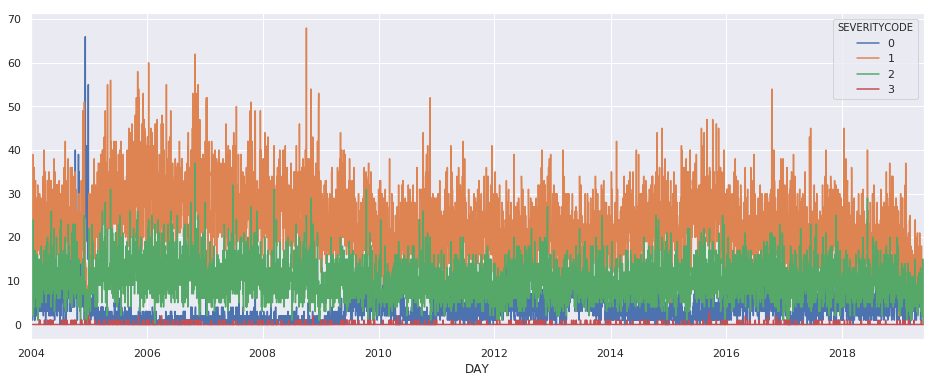

In [17]:
data_ts = data.groupby(['DAY', 'SEVERITYCODE']).size().unstack().fillna(0)
data_ts.plot(figsize=(16,6))

## Total number of collisions

Let's put the `SEVERITYCODE`s on hold for a second, and just focus on the number of collisions per day.

In this way it becomes clear that the number of auto collisions in Seattle seems to be dropping.

In [18]:
data_ts['ALL'] = data_ts.sum(axis=1)

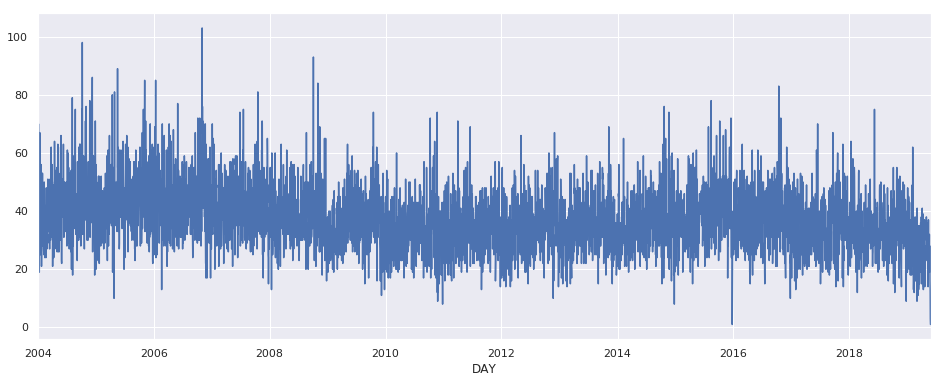

In [19]:
data_ts.ALL.plot(figsize=(16,6))

## Seasonality plots of the same data

In [20]:
tmp = data_ts.ALL[data_ts.index.year == 2004]
tmp.index

DatetimeIndex(['2004-01-01', '2004-01-02', '2004-01-03', '2004-01-04',
               '2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-10',
               ...
               '2004-12-22', '2004-12-23', '2004-12-24', '2004-12-25',
               '2004-12-26', '2004-12-27', '2004-12-28', '2004-12-29',
               '2004-12-30', '2004-12-31'],
              dtype='datetime64[ns]', name='DAY', length=366, freq=None)

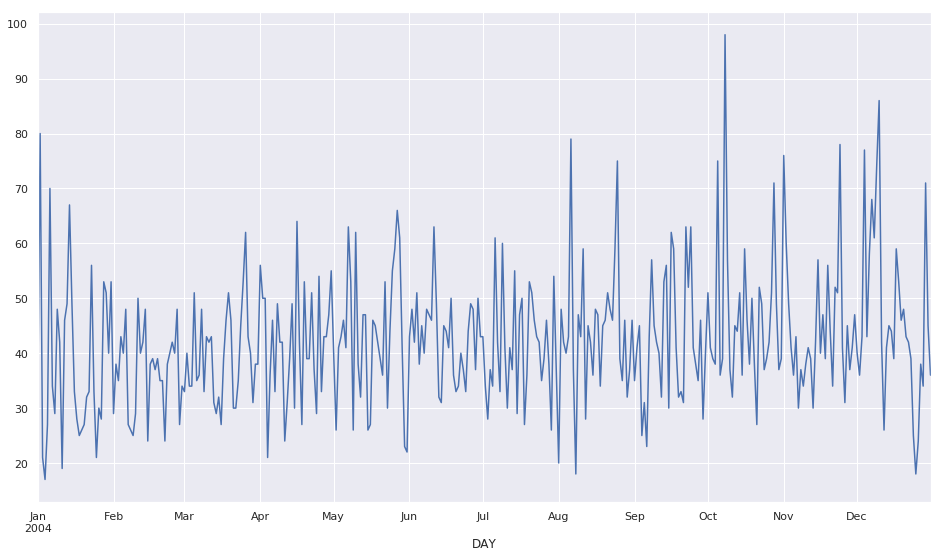

In [21]:
tmp.plot(figsize=(16,9))

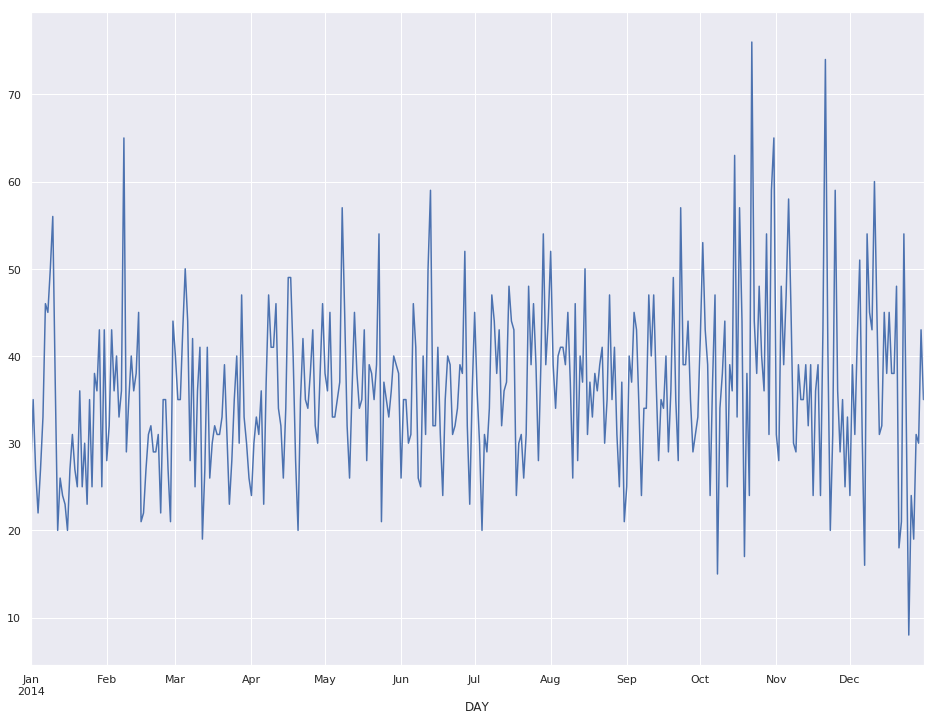

In [22]:
data_ts.ALL[data_ts.index.year == 2014].plot(figsize=(16,12))

In [23]:
data_ts.ALL

DAY
2004-01-01    30.0
2004-01-02    80.0
2004-01-03    21.0
2004-01-04    17.0
2004-01-05    27.0
2004-01-06    70.0
2004-01-07    34.0
2004-01-08    29.0
2004-01-09    48.0
2004-01-10    42.0
2004-01-11    19.0
2004-01-12    46.0
2004-01-13    49.0
2004-01-14    67.0
2004-01-15    49.0
2004-01-16    33.0
2004-01-17    28.0
2004-01-18    25.0
2004-01-19    26.0
2004-01-20    27.0
2004-01-21    32.0
2004-01-22    33.0
2004-01-23    56.0
2004-01-24    33.0
2004-01-25    21.0
2004-01-26    30.0
2004-01-27    28.0
2004-01-28    53.0
2004-01-29    51.0
2004-01-30    40.0
              ... 
2019-04-28    23.0
2019-04-29    23.0
2019-04-30    25.0
2019-05-01    38.0
2019-05-02    30.0
2019-05-03    35.0
2019-05-04    25.0
2019-05-05    26.0
2019-05-06    29.0
2019-05-07    33.0
2019-05-08    36.0
2019-05-09    27.0
2019-05-10    27.0
2019-05-11    31.0
2019-05-12    14.0
2019-05-13    26.0
2019-05-14    37.0
2019-05-15    20.0
2019-05-16    29.0
2019-05-17    23.0
2019-05-18    19.0
2019-05-

## Plotting rolling statistics

Wanting to check a rolling mean / rolling variance of the data. I've used a few windows and found that a window of about 30 preserves trends while reducing the volatility of the data.

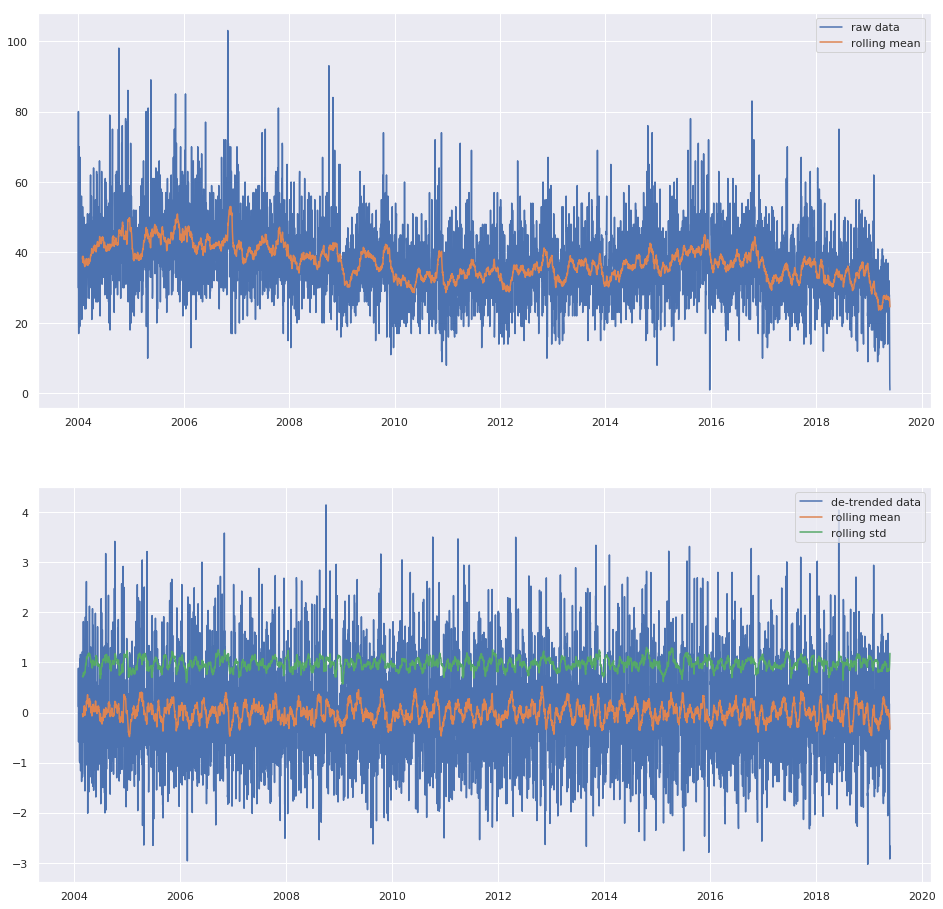

In [24]:
window=30

data_z = (data_ts.ALL - data_ts.ALL.rolling(window=window).mean()) / data_ts.ALL.rolling(window=window).std()
data_zp = data_z - data_z.shift(window)

fig, ax = plt.subplots(2, figsize=(16,16))

ax[0].plot(data_ts.ALL.index, data_ts.ALL, label='raw data')
ax[0].plot(data_ts.ALL.rolling(window=window).mean(), label='rolling mean')
ax[0].legend()

ax[1].plot(data_z.index, data_z, label='de-trended data')
ax[1].plot(data_z.rolling(window=window).mean(), label='rolling mean')
ax[1].plot(data_z.rolling(window=window).std(), label='rolling std')
ax[1].legend()

# Ready to do time series analysis now

Like I mentioned before, we'll start with the totality of collisions, then later group into severity levels.

## Check Stationarity

Uses the Dickey-Fuller test for stationarity, which concludes the data is stationary with very low p-value

In [25]:
def df_test(some_data, autolag='AIC'):
    dftest = adfuller(some_data, autolag=autolag)
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [26]:
df_test(data_ts.ALL)

Test statistic = -5.221
P-value = 0.000
Critical values :
	1%: -3.4315186854422413 - The data is  stationary with 99% confidence
	5%: -2.8620564447336996 - The data is  stationary with 95% confidence
	10%: -2.5670449020697306 - The data is  stationary with 90% confidence


In [27]:
df_test(data_z.dropna())

Test statistic = -17.420
P-value = 0.000
Critical values :
	1%: -3.4315258302408598 - The data is  stationary with 99% confidence
	5%: -2.862059601412059 - The data is  stationary with 95% confidence
	10%: -2.567046582468121 - The data is  stationary with 90% confidence
